## Import libraries

In [603]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

plt.style.use('seaborn-poster')

## Data structuring

In [604]:
positiveSalivaSensor1Path = '/content/drive/MyDrive/datasets/voltametria/Sensor 1 (AA)/Saliva/Positiva'
positiveSalivaSensor2Path = '/content/drive/MyDrive/datasets/voltametria/Sensor 2 (PEI)/Saliva/Positiva'
negativeSalivaSensor1Path = '/content/drive/MyDrive/datasets/voltametria/Sensor 1 (AA)/Saliva/Negativa'
negativeSalivaSensor2Path = '/content/drive/MyDrive/datasets/voltametria/Sensor 2 (PEI)/Saliva/Negativa'
positiveUrineSensor1Path = '/content/drive/MyDrive/datasets/voltametria/Sensor 1 (AA)/Urina/Positiva'
positiveUrineSensor2Path = '/content/drive/MyDrive/datasets/voltametria/Sensor 2 (PEI)/Urina/Positiva'
negativeUrineSensor1Path = '/content/drive/MyDrive/datasets/voltametria/Sensor 1 (AA)/Urina/Negativa'
negativeUrineSensor2Path = '/content/drive/MyDrive/datasets/voltametria/Sensor 2 (PEI)/Urina/Negativa'

def getFilesList():
    salivaFiles = next(os.walk(positiveSalivaSensor1Path), (None, None, []))[2] +\
                  next(os.walk(positiveSalivaSensor2Path), (None, None, []))[2] +\
                  next(os.walk(negativeSalivaSensor1Path), (None, None, []))[2] +\
                  next(os.walk(negativeSalivaSensor2Path), (None, None, []))[2]

    urineFiles = next(os.walk(positiveUrineSensor1Path), (None, None, []))[2] +\
                 next(os.walk(positiveUrineSensor2Path), (None, None, []))[2] +\
                 next(os.walk(negativeUrineSensor1Path), (None, None, []))[2] +\
                 next(os.walk(negativeUrineSensor2Path), (None, None, []))[2]

    return salivaFiles, urineFiles

def getFilesToDataframe(path, filelist):
    df = pd.read_csv(f'{path}/{filelist}', delimiter = "\t", header = None, decimal=",")
    return df

def convertColumnsToNumbers(df):
    df.replace(',', '.', inplace = True, regex = True)
    df = df.astype(float)
    return df

def applyLog10(df):
    df[0] = np.log10(df[0]+1)
    return df

def roundCols(df):
    cols = [np.round(x, 3) for x in df.columns.values]
    df.columns = cols
    return df

def preprocessingData(df, pathName):
    new_df = convertColumnsToNumbers(df)
    new_df = applyLog10(new_df)
    new_df = new_df.set_index(0).T
    new_df = roundCols(new_df)
    new_df['target'] = 1 if 'positive' in pathName else 0
    new_df['sensorType'] = 1 if '1' in pathName else 2
    new_df['substanceType'] = 'Saliva' if 'Saliva' in pathName else 'Urine'
    return new_df

def mergeData(df1, df2, how):
    return pd.merge(df1, df2, how = how)

def resetIndexes(dfs, inplace, drop):
    for df in dfs:
        df.reset_index(inplace = inplace, drop = drop)

def concatAllFiles(urlFiles, fileList):
    df_merged = pd.DataFrame()
    df_sensor1 = pd.DataFrame()
    df_sensor2 = pd.DataFrame()
    n = 0

    for pathName, filePath in urlFiles.items():
        for i in range(1, 11):
            filename = str(i) + '.txt'
            new_df = getFilesToDataframe(filePath, filename)

            if '1' in pathName:
                sample = preprocessingData(new_df, pathName)
                df_sensor1 = pd.concat([df_sensor1, sample])
            else:
                sample = preprocessingData(new_df, pathName)
                df_sensor2 = pd.concat([df_sensor2, sample])

    #columnsSensor1 = set(df_sensor1.columns)
    #columnsSensor2 = set(df_sensor2.columns)
    #mergedColumns = columnsSensor2.intersection(columnsSensor1)

    df_merged = mergeData(df_sensor1, df_sensor2, 'outer')
    resetIndexes([df_merged, df_sensor1, df_sensor2], True, True)

    return df_merged, df_sensor1, df_sensor2

        

salivaFiles, urineFiles = getFilesList()

allFiles = {'salivaFiles': salivaFiles, 
            'urineFiles': urineFiles}

urlFiles = {'positiveSalivaSensor1': positiveSalivaSensor1Path, 
            'positiveSalivaSensor2': positiveSalivaSensor2Path, 
            'negativeSalivaSensor1': negativeSalivaSensor1Path, 
            'negativeSalivaSensor2': negativeSalivaSensor2Path, 
            'positiveUrineSensor1': positiveUrineSensor1Path, 
            'positiveUrineSensor2': positiveUrineSensor2Path, 
            'negativeUrineSensor1': negativeUrineSensor1Path, 
            'negativeUrineSensor2': negativeUrineSensor2Path}


df, df1, df2 = concatAllFiles(urlFiles, allFiles)  

raw_data = {
    'sensor1': df1,
    'sensor2': df2,
}


raw_data['sensor1'].head()

,-0.222,-0.211,-0.201,-0.19,-0.181,-0.171,-0.161,-0.152,-0.143,-0.134,...,0.232,0.236,0.24,0.243,0.247,0.251,0.254,target,sensorType,substanceType
0,1.4e-06,9.8e-07,7.9e-07,6.8e-07,6.2e-07,6e-07,6e-07,6.2e-07,6.5e-07,6.9e-07,...,4.6e-07,5.6e-07,6.6e-07,7.5e-07,8.4e-07,9.3e-07,1e-06,1,1,Saliva
1,6e-07,1.1e-07,-1.3e-07,-2.6e-07,-3.4e-07,-3.8e-07,-3.9e-07,-3.7e-07,-3.3e-07,-2.7e-07,...,3.1e-07,4.1e-07,5.2e-07,6.5e-07,7.8e-07,9.1e-07,1.1e-06,1,1,Saliva
2,3.7e-07,-1.2e-07,-3.6e-07,-5e-07,-5.9e-07,-6.3e-07,-6.4e-07,-6.3e-07,-5.9e-07,-5.3e-07,...,2.5e-07,3.5e-07,4.5e-07,5.8e-07,7.1e-07,8.5e-07,1e-06,1,1,Saliva
3,1.7e-06,1.3e-06,1.1e-06,9.9e-07,9.2e-07,8.9e-07,8.8e-07,8.8e-07,9e-07,9.2e-07,...,2.7e-07,3.3e-07,3.8e-07,4.4e-07,5e-07,5.6e-07,6.3e-07,1,1,Saliva
4,9.8e-07,4.8e-07,2.3e-07,7.9e-08,-1.8e-08,-7.2e-08,-1e-07,-1e-07,-8.6e-08,-5.6e-08,...,1.4e-07,2.1e-07,2.8e-07,3.7e-07,4.6e-07,5.7e-07,6.8e-07,1,1,Saliva


## Data visualization

<ipython-input-605-0ebf961eb57e>:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  new_df = df.drop(array, axis)


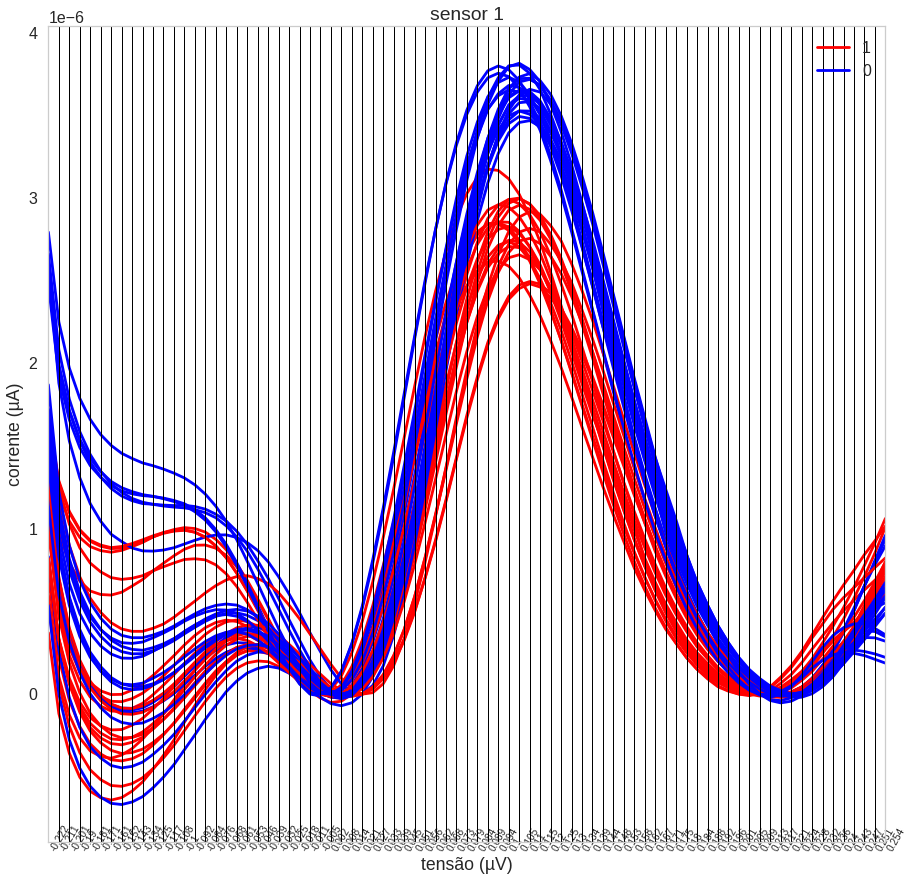

In [605]:
def plotParallelCoordinates(df, title, xlabel, ylabel, target = 'target', colors = ['red', 'blue']):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,15))

    new_df = df.copy()

    pd.plotting.parallel_coordinates(frame = new_df, class_column = target, ax = ax, color = colors)
    ax.set(title = title,
           xlabel = xlabel,
           ylabel = ylabel)
    plt.xticks(rotation = 60, fontsize = 10, va='bottom', ha='left')
    #ax.set_xticklabels(rotation = (45), fontsize = 10, va='bottom', ha='left')
    plt.show()

def dropColumns(df, array, axis):
    new_df = df.drop(array, axis)
    return new_df

plotParallelCoordinates(df = dropColumns(raw_data['sensor1'], ['sensorType', 'substanceType'], 1),
                        title = 'sensor 1',
                        xlabel = 'tensão (µV)',
                        ylabel = 'corrente (µA)',
                        target = 'target',
                        colors = ['red', 'blue'],
                        )


<ipython-input-605-0ebf961eb57e>:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  new_df = df.drop(array, axis)


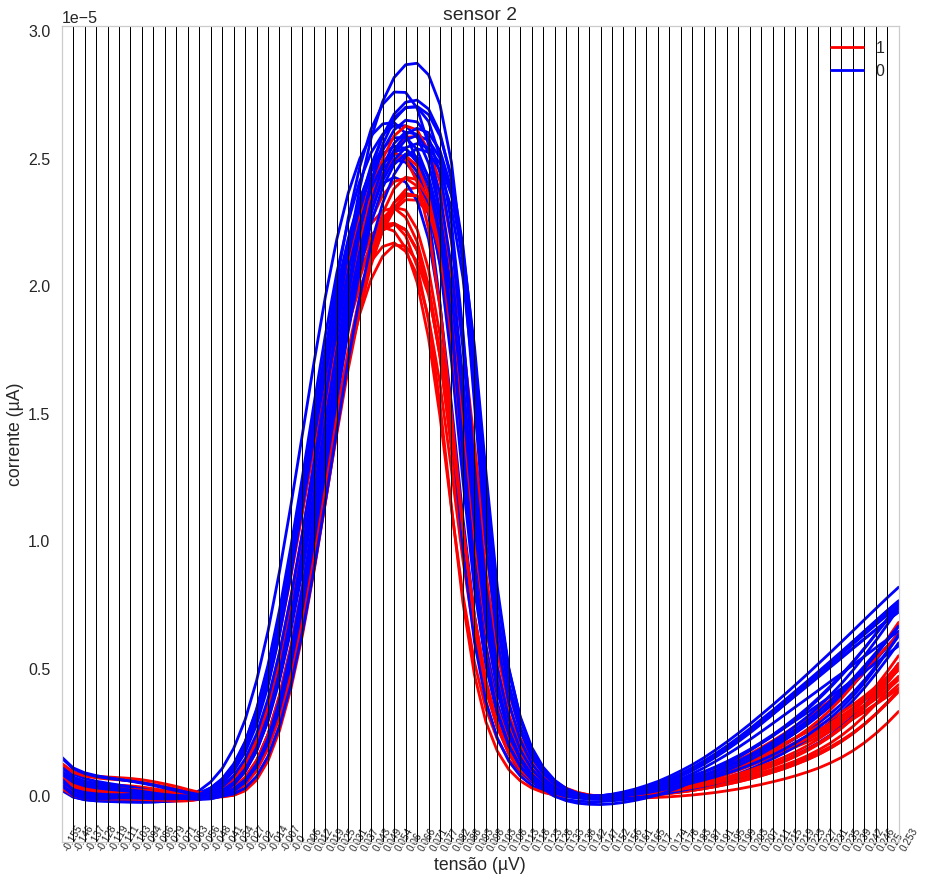

In [606]:
plotParallelCoordinates(df = dropColumns(raw_data['sensor2'], ['sensorType', 'substanceType'], 1),
                        title = 'sensor 2',
                        xlabel = 'tensão (µV)',
                        ylabel = 'corrente (µA)',
                        target = 'target',
                        colors = ['red', 'blue'],
                        )


## Descriptive statistics

In [607]:
from scipy.stats import kurtosis, skew

def extractingStatistics(df):

    stats_df = pd.DataFrame(columns = ['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurtosis'])

    for i in range(len(df)):
        sample = df.iloc[i,:-3].values
        stats_df.loc[i] = [np.mean(sample), 
                           np.std(sample),
                           np.min(sample),
                           np.quantile(sample, 0.25),
                           np.quantile(sample, 0.5),
                           np.quantile(sample, 0.75),
                           np.max(sample),
                           skew(list(sample)),
                           kurtosis(list(sample))]
    return stats_df

stats_data = {}

stats_data['sensor1'] = extractingStatistics(raw_data['sensor1'])
stats_data['sensor2'] = extractingStatistics(raw_data['sensor2'])

In [608]:
stats_data['sensor1'].head()

,mean,std,min,25%,50%,75%,max,skew,kurtosis
0,9.4e-07,8.3e-07,-2.4e-09,3.1e-07,7.2e-07,1.2e-06,2.9e-06,1,-0.052
1,6.7e-07,9e-07,-3.9e-07,3.9e-08,3.1e-07,1.1e-06,2.7e-06,1.1,-0.078
2,6.1e-07,9.5e-07,-6.4e-07,1.9e-08,2.5e-07,1e-06,2.7e-06,0.97,-0.17
3,1e-06,9.5e-07,0,2.7e-07,8.8e-07,1.5e-06,3.2e-06,0.96,-0.22
4,7.6e-07,9.6e-07,-1e-07,7.9e-08,3.3e-07,1.1e-06,3e-06,1.2,-0.017


In [609]:
stats_data['sensor2'].head()

,mean,std,min,25%,50%,75%,max,skew,kurtosis
0,5.4e-06,8.1e-06,-3.6e-08,2.7e-07,1.4e-06,5.3e-06,2.6e-05,1.6,0.94
1,5e-06,7.8e-06,-6.8e-08,7.7e-08,9.5e-07,4.8e-06,2.5e-05,1.6,0.98
2,4.3e-06,6.8e-06,-7.6e-08,6.8e-08,7e-07,4e-06,2.2e-05,1.6,0.96
3,4.5e-06,7.1e-06,-1.9e-07,5.3e-08,8.7e-07,4.2e-06,2.2e-05,1.6,0.93
4,5e-06,7.5e-06,-4.2e-08,3.2e-07,1.3e-06,4.7e-06,2.4e-05,1.5,0.84


## Peaks

In [610]:
## PICOS

from scipy.signal import find_peaks, peak_prominences, peak_widths


def creatingPeakDataFrame(df, band_list, prom_list, width_half_list, width_full_list):
    pd.set_option('display.float_format', '{:.2g}'.format)

    peaks = pd.DataFrame({'band': np.array(band_list), 
                          'prominence': np.array(prom_list),
                          'half_width': np.array(width_half_list),
                          'full_width': np.array(width_full_list)
                          })
    
    peaks['q_factor'] = peaks['prominence']/peaks['half_width']
    peaks['target'] = df['target']

    return peaks

def calculateWidth(x, width_peaks):
    return x.index[int(width_peaks[3])] - x.index[int(width_peaks[2])]

def extractingPeakMeasures(x, peak_location, prominences):

    # Find the location of the peak with the maximum prominence
    peak_index = peak_location[np.argmax(prominences)]
    # Calculate the frequency (band) of the peak
    band = x.index[peak_index]

    # Calculate the full-width and half-width of the peak
    half_width_peaks = peak_widths(x, [peak_index], rel_height = 0.5)
    full_width_peaks = peak_widths(x, [peak_index], rel_height = 1.0)

    half_width = calculateWidth(x, half_width_peaks)
    full_width = calculateWidth(x, full_width_peaks)

    return band, half_width, full_width


def extractingPeaks(x):
    peak_location, _ = find_peaks(x)
    prominences = peak_prominences(x, peak_location)[0]
    max_prom = np.max(prominences)
    others_prom = np.delete(prominences, np.argmax(prominences))

    return peak_location, prominences, max_prom, others_prom


def findPeaks(df):
    band_list=[]
    prom_list=[]
    width_half_list=[]
    width_full_list=[]

    for i in range(len(df)):
        x = df.iloc[i,:-3]

        peak_location, prominences, max_prom, others_prom = extractingPeaks(x)
        otherPromGreaterThanPeak = others_prom > max_prom/3

        if not otherPromGreaterThanPeak.any():
            band, width_half, width_full = extractingPeakMeasures(x, peak_location, prominences)

            band_list.append(band)
            prom_list.append(max_prom)
            width_half_list.append(width_half)
            width_full_list.append(width_full)
    
    peaks = creatingPeakDataFrame(df, band_list, prom_list, width_half_list, width_full_list)
    return peaks

peak_data = {}
peak_data['sensor1'] = findPeaks(raw_data['sensor1'])
peak_data['sensor2'] = findPeaks(raw_data['sensor2'])

In [611]:
peak_data['sensor1'].head()

,band,prominence,half_width,full_width,q_factor,target
0,0.094,2.9e-06,0.094,0.2,3e-05,1
1,0.1,2.7e-06,0.088,0.2,3.1e-05,1
2,0.1,2.7e-06,0.088,0.3,3.1e-05,1
3,0.089,3.2e-06,0.094,0.21,3.4e-05,1
4,0.1,3e-06,0.088,0.2,3.4e-05,1


In [612]:
peak_data['sensor2'].head()

,band,prominence,half_width,full_width,q_factor,target
0,0.066,2.6e-05,0.081,0.2,0.00032,1
1,0.06,2.5e-05,0.076,0.21,0.00033,1
2,0.054,2.2e-05,0.076,0.21,0.00029,1
3,0.054,2.2e-05,0.076,0.21,0.0003,1
4,0.066,2.4e-05,0.074,0.2,0.00032,1


## Feature selection

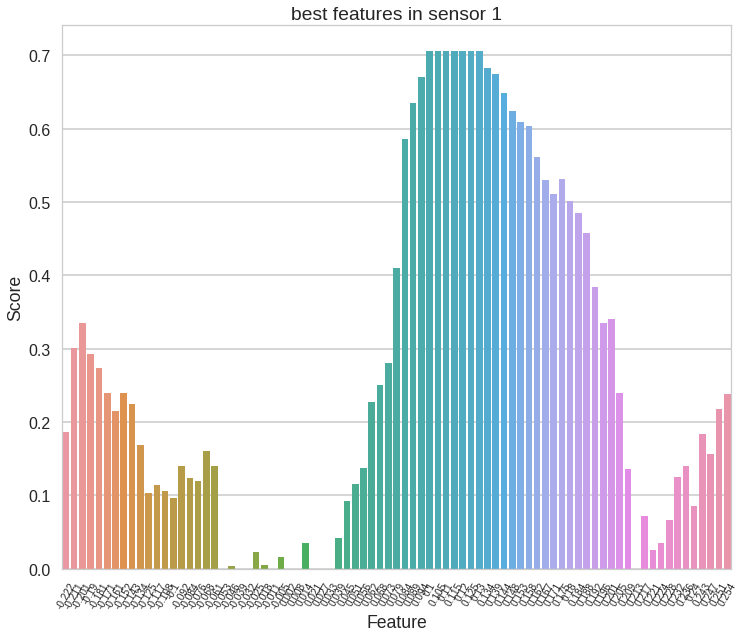

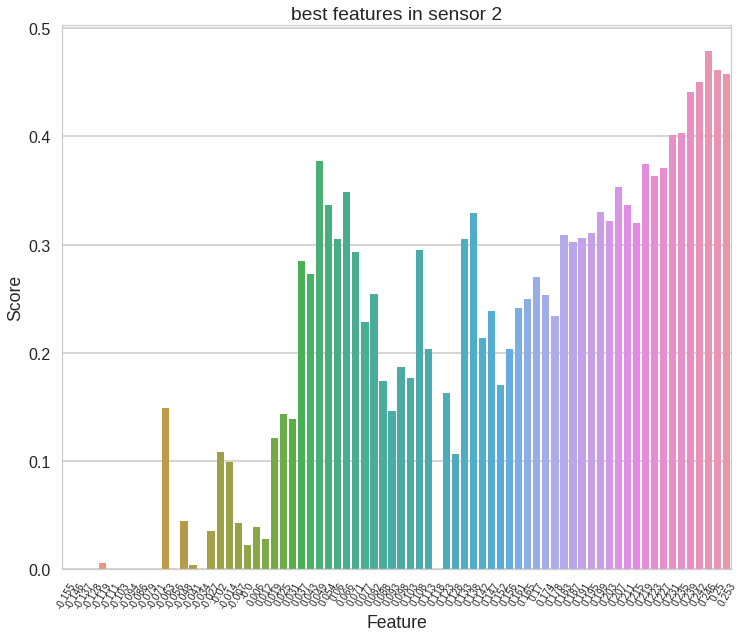

In [613]:
## replicar as 5 features selection do arquivo mi
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

def splitData(df):
    x = df.drop(['target', 'sensorType', 'substanceType'], axis = 1)
    y = df['target']

    return x, y

def createEstimatorScoreDF(x, estimatorScore, sortedIdx):
    estimatorScoreDF = pd.DataFrame(estimatorScore[sortedIdx[::-1]], index=x.columns[sortedIdx[::-1]], columns=['score'])
    return estimatorScoreDF

def plotEstimatorScore(x, sortedIdx, estimatorScore, title):
    fig, ax = plt.subplots(1,1, figsize = (12,10))
    sns.barplot(x = x.columns[sortedIdx], y = estimatorScore[sortedIdx])
    ax.set(xlabel = 'Feature', ylabel = 'Score', title = title)
    plt.xticks(rotation = 60, fontsize = 10)
    plt.show()

def estimatorScore(x, y, title):
    estimatorScore = mutual_info_classif(x, y, random_state = 42)
    sortedIdx = np.argsort(estimatorScore)

    estimatorScoreDF = createEstimatorScoreDF(x, estimatorScore, sortedIdx)

    plotEstimatorScore(x, sortedIdx, estimatorScore, title)

    return estimatorScoreDF

def selectKBestFeatures(k, estimatorScore, df):
    k_best = k
    k_best_features = estimatorScore.iloc[:k_best, :].index
    k_best_df = df[k_best_features]
    return k_best_df

estimator_scores_df = {}

X_sensor1, y_sensor1 = splitData(raw_data['sensor1'])
estimator_scores_df['sensor1'] = estimatorScore(X_sensor1, y_sensor1, 'best features in sensor 1')

X_sensor2, y_sensor2 = splitData(raw_data['sensor2'])
estimator_scores_df['sensor2'] = estimatorScore(X_sensor2, y_sensor2, 'best features in sensor 2')


k_best_df = {}
k_best_df['sensor1'] = selectKBestFeatures(5, estimator_scores_df['sensor1'], raw_data['sensor1'])
k_best_df['sensor2'] = selectKBestFeatures(5, estimator_scores_df['sensor2'], raw_data['sensor2'])

plt.show()

In [614]:
k_best_df['sensor1'].head()

,0.105,0.11,0.115,0.12,0.125
0,2.7e-06,2.6e-06,2.5e-06,2.3e-06,2.1e-06
1,2.7e-06,2.6e-06,2.5e-06,2.4e-06,2.2e-06
2,2.7e-06,2.7e-06,2.6e-06,2.4e-06,2.3e-06
3,3e-06,2.9e-06,2.7e-06,2.6e-06,2.3e-06
4,3e-06,2.9e-06,2.8e-06,2.7e-06,2.5e-06


In [615]:
k_best_df['sensor2'].head()

,0.246,0.25,0.253,0.242,0.239
0,3.6e-06,3.9e-06,4.2e-06,3.3e-06,3.1e-06
1,3.2e-06,3.6e-06,4.1e-06,2.8e-06,2.5e-06
2,2.5e-06,2.9e-06,3.3e-06,2.1e-06,1.8e-06
3,3.2e-06,3.7e-06,4.2e-06,2.8e-06,2.5e-06
4,3.6e-06,4e-06,4.4e-06,3.3e-06,3e-06


## Clustering

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

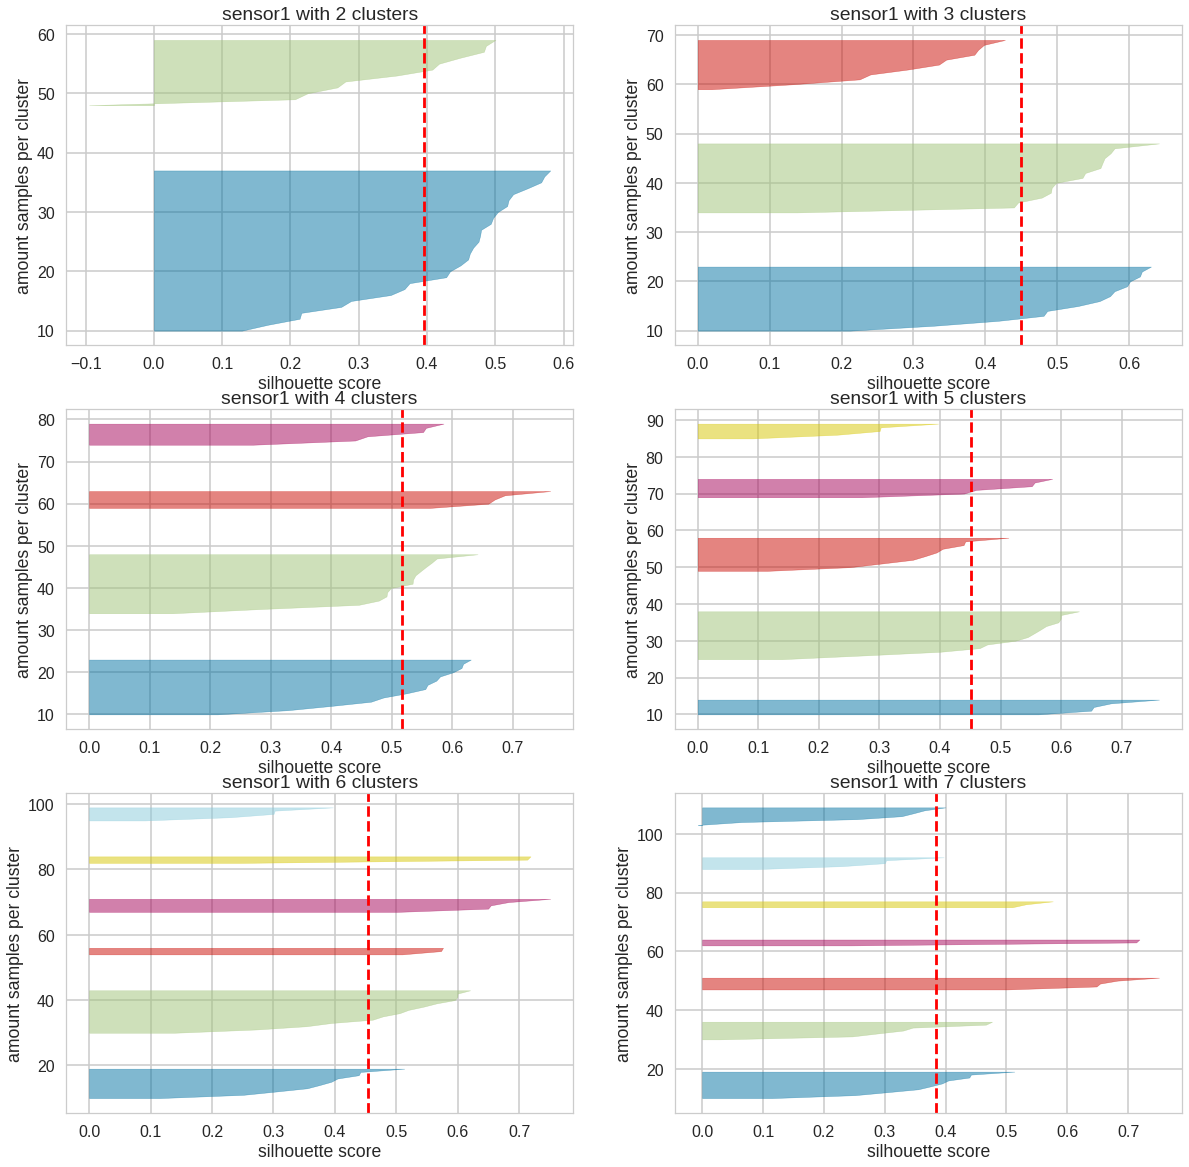

In [616]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

def plotSilhoetteVisualizer(X, Ks, ax, sensorName):
    silhouette_coef_list = []
    for k in Ks:
        np.random.seed(42)
        km_model = KMeans(n_clusters = k)
        q, mod = divmod(k,2)
        visualizer = SilhouetteVisualizer(km_model, colors = 'yellowbrick', ax = ax[q-1][mod])
        ax[q-1][mod].set(title = f'{sensorName} with {k} clusters', 
                         xlabel = 'silhouette score', 
                         ylabel = 'amount samples per cluster')
        visualizer.fit(X)
        #print(f"{sensorName}: the silhouette's score for {k} clusters is {visualizer.silhouette_score_}")
        silhouette_coef_list.append(visualizer.silhouette_score_)
    return silhouette_coef_list


fig, ax = plt.subplots(3, 2, figsize = (20, 20))

raw_silhouette_scores = {}
raw_silhouette_scores['Ks'] = [2,3,4,5,6,7]
raw_silhouette_scores['sensor1'] = plotSilhoetteVisualizer(X = raw_data['sensor1'].iloc[:, :-3],
                                                           Ks = raw_silhouette_scores['Ks'], 
                                                           ax = ax, 
                                                           sensorName = 'sensor1'
                                                           )

plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

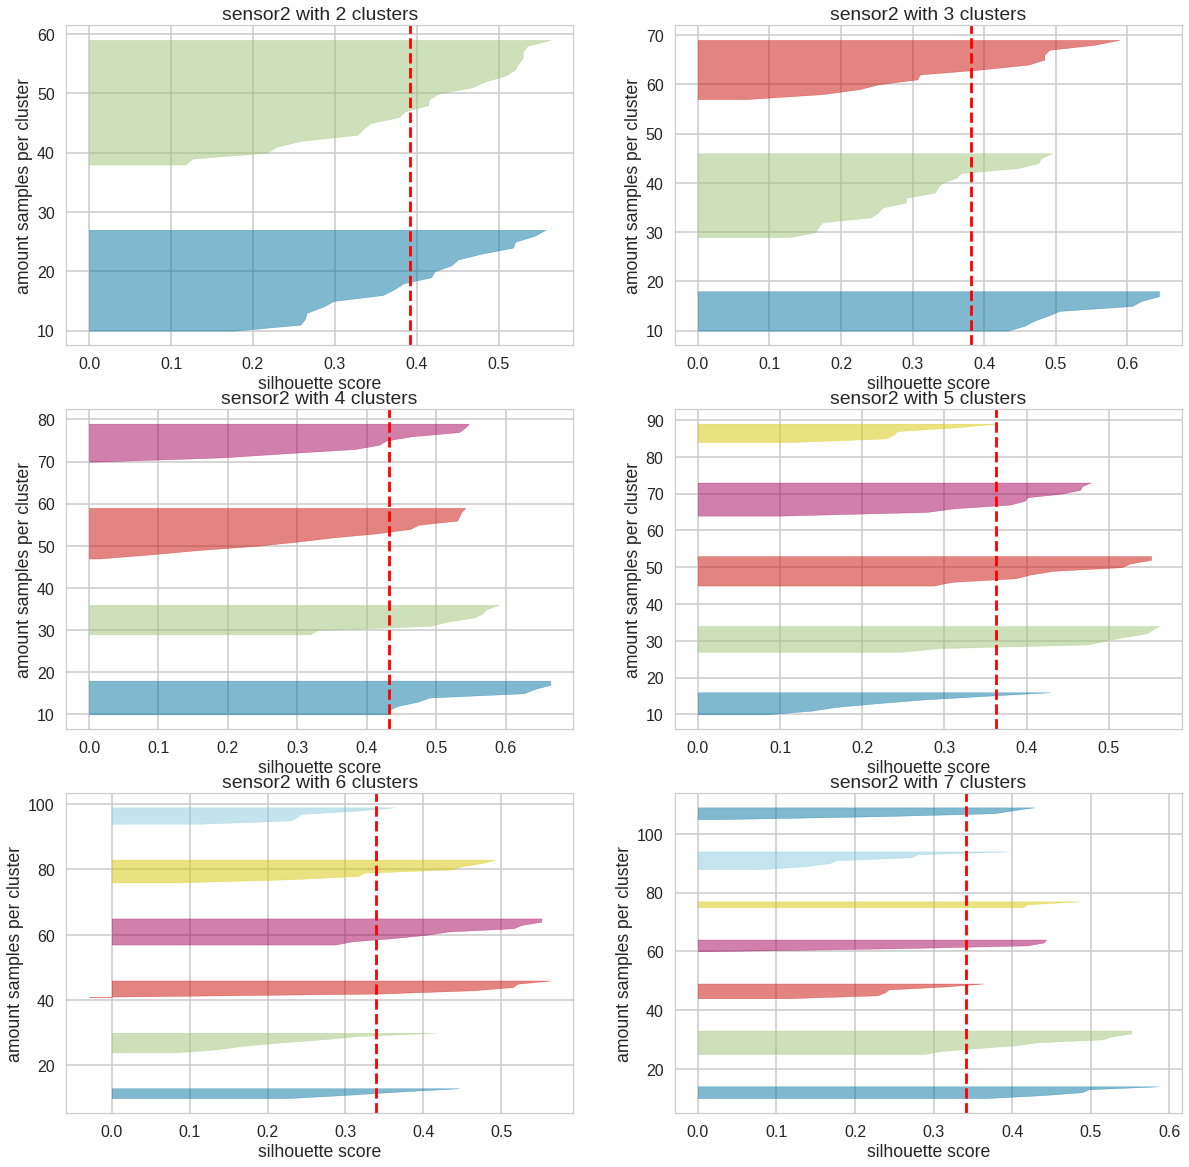

In [617]:
fig, ax = plt.subplots(3, 2, figsize = (20, 20))

raw_silhouette_scores['sensor2'] = plotSilhoetteVisualizer(X = raw_data['sensor2'].iloc[:, :-3],
                                                           Ks = raw_silhouette_scores['Ks'], 
                                                           ax = ax, 
                                                           sensorName = 'sensor2'
                                                           )
plt.show()

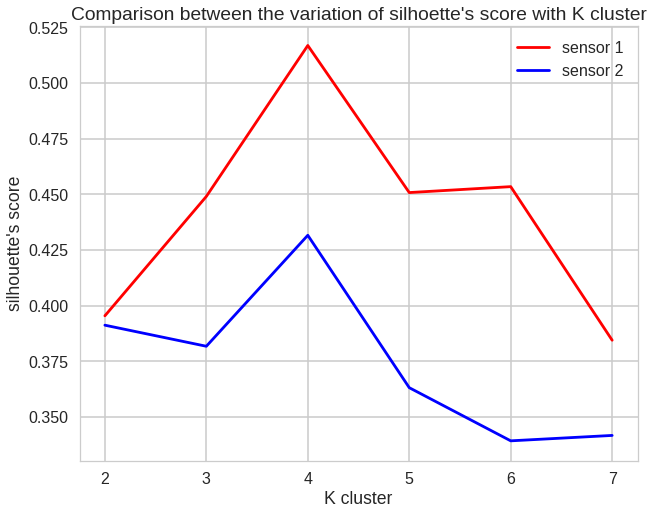

In [618]:
def plot_silhouette_score(silhouette_scores, ax):
    sns.lineplot(data = silhouette_scores, x= 'Ks', y = 'sensor1', color = 'red', ax=ax, label = 'sensor 1')
    sns.lineplot(data = silhouette_scores, x= 'Ks', y = 'sensor2', color = 'blue', ax=ax, label = 'sensor 2')
    ax.set(title = "Comparison between the variation of silhoette's score with K cluster",
           xlabel = 'K cluster',
           ylabel = "silhouette's score"
    )

    plt.legend()


fig, ax = plt.subplots(1, 1, figsize = (10, 8))
plot_silhouette_score(raw_silhouette_scores, ax)

plt.show()

In [619]:
def clusterPred(X, k):
    #print(X.columns, k)
    kmeans = KMeans(n_clusters = k)
    cluster_pred = kmeans.fit_predict(X)
    return cluster_pred

def getMaxSilhouetteScore(array):
    return max(array)

def getIndexArray(array, value):
    return array.index(value)

def getBestK(array, Ks):
    max_silhouette = getMaxSilhouetteScore(array)
    k_position = getIndexArray(array, max_silhouette)
    k = Ks[k_position]
    return k



best_K_sensor1 = getBestK(raw_silhouette_scores['sensor1'], raw_silhouette_scores['Ks'])
raw_data['sensor1']['clusterPred'] = clusterPred(X = raw_data['sensor1'].iloc[:,:-3],
                                                 k = best_K_sensor1)

best_K_sensor2 = getBestK(raw_silhouette_scores['sensor2'], raw_silhouette_scores['Ks'])
raw_data['sensor2']['clusterPred'] = clusterPred(X = raw_data['sensor2'].iloc[:,:-3],
                                                 k = best_K_sensor2)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<ipython-input-605-0ebf961eb57e>:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  new_df = df.drop(array, axis)


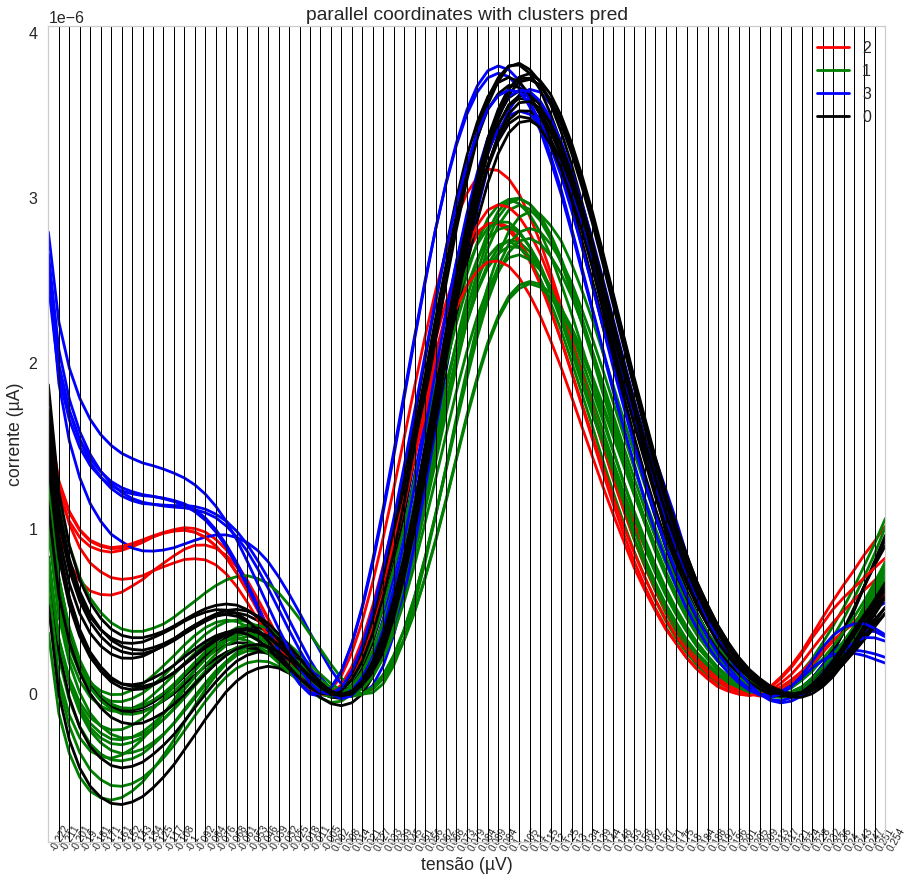

In [620]:
plotParallelCoordinates(
    df = dropColumns(raw_data['sensor1'], ['target', 'substanceType', 'sensorType'], 1),
    title = 'parallel coordinates with clusters pred',
    xlabel = 'tensão (µV)',
    ylabel = 'corrente (µA)',
    target = 'clusterPred',
    colors = ['red', 'green', 'blue', 'black'],
)

<ipython-input-605-0ebf961eb57e>:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  new_df = df.drop(array, axis)


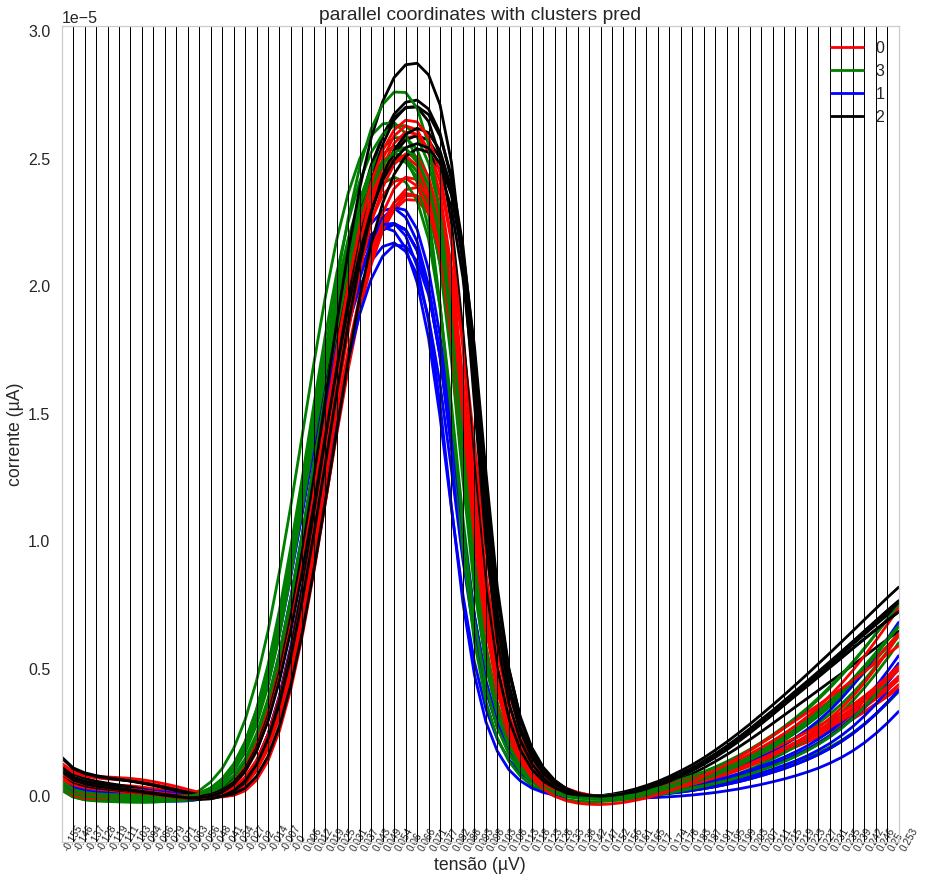

In [621]:
plotParallelCoordinates(
    df = dropColumns(raw_data['sensor2'], ['target', 'substanceType', 'sensorType'], 1),
    title = 'parallel coordinates with clusters pred',
    xlabel = 'tensão (µV)',
    ylabel = 'corrente (µA)',
    target = 'clusterPred',
    colors = ['red', 'green', 'blue', 'black'],
)

## PCA

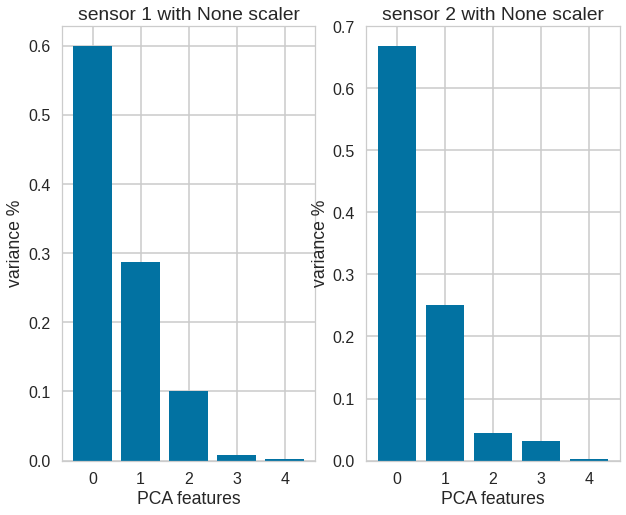

In [622]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


def calculatingPCA(df, nameSensor, n_components, ax, scaler = None):
    X = df.drop(['target', 'sensorType', 'substanceType', 'clusterPred'], axis = 1)

    if scaler != None:
        X = scaler.fit_transform(X)

    pca = PCA(n_components = n_components)
    principalComponents = pca.fit_transform(X)
    
    new_df = pd.DataFrame(principalComponents)
    new_df['target'] = df['target'].values

    features = np.arange(pca.n_components)
    ax.bar(features, pca.explained_variance_ratio_)
    ax.set(xlabel = 'PCA features', ylabel = 'variance %', xticks = features, title = f'{nameSensor} with {scaler} scaler')
    
    return new_df


fig, ax = plt.subplots(1, 2, figsize = (10, 8))

PCA_components = {}
PCA_components['sensor1'] = calculatingPCA(raw_data['sensor1'], 'sensor 1', 5, ax[0])
PCA_components['sensor2'] = calculatingPCA(raw_data['sensor2'], 'sensor 2', 5, ax[1])

plt.show()

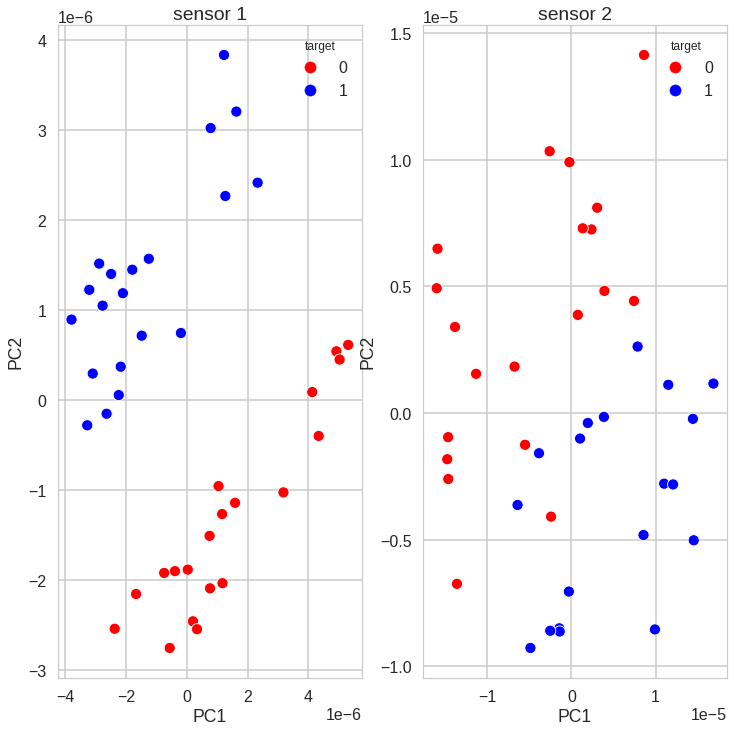

In [623]:
def writeInPlot(df, ax):
    for i in range(len(df)):
        name = 'positive' if df['target'][i] == 1 else 'negative'
        ax.text(x = df.loc[i, 0], y = df.loc[i,1], s = name)


def plotPCA(df, title, ax, target = 'target', palette = ['red', 'blue']):
    
    sns.scatterplot(data = df, x = 0, y = 1, hue = target, palette = palette, ax = ax)
    ax.set(xlabel = 'PC1', ylabel = 'PC2', title = title)
    #writeInPlot(df, ax)
    

fig, ax = plt.subplots(1, 2, figsize = (12,12))

plotPCA(df = PCA_components['sensor1'], 
        title = 'sensor 1', 
        ax = ax[0]
        )

plotPCA(df = PCA_components['sensor2'], 
        title = 'sensor 2', 
        ax = ax[1]
        )

plt.show()

## Clustering PCA

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

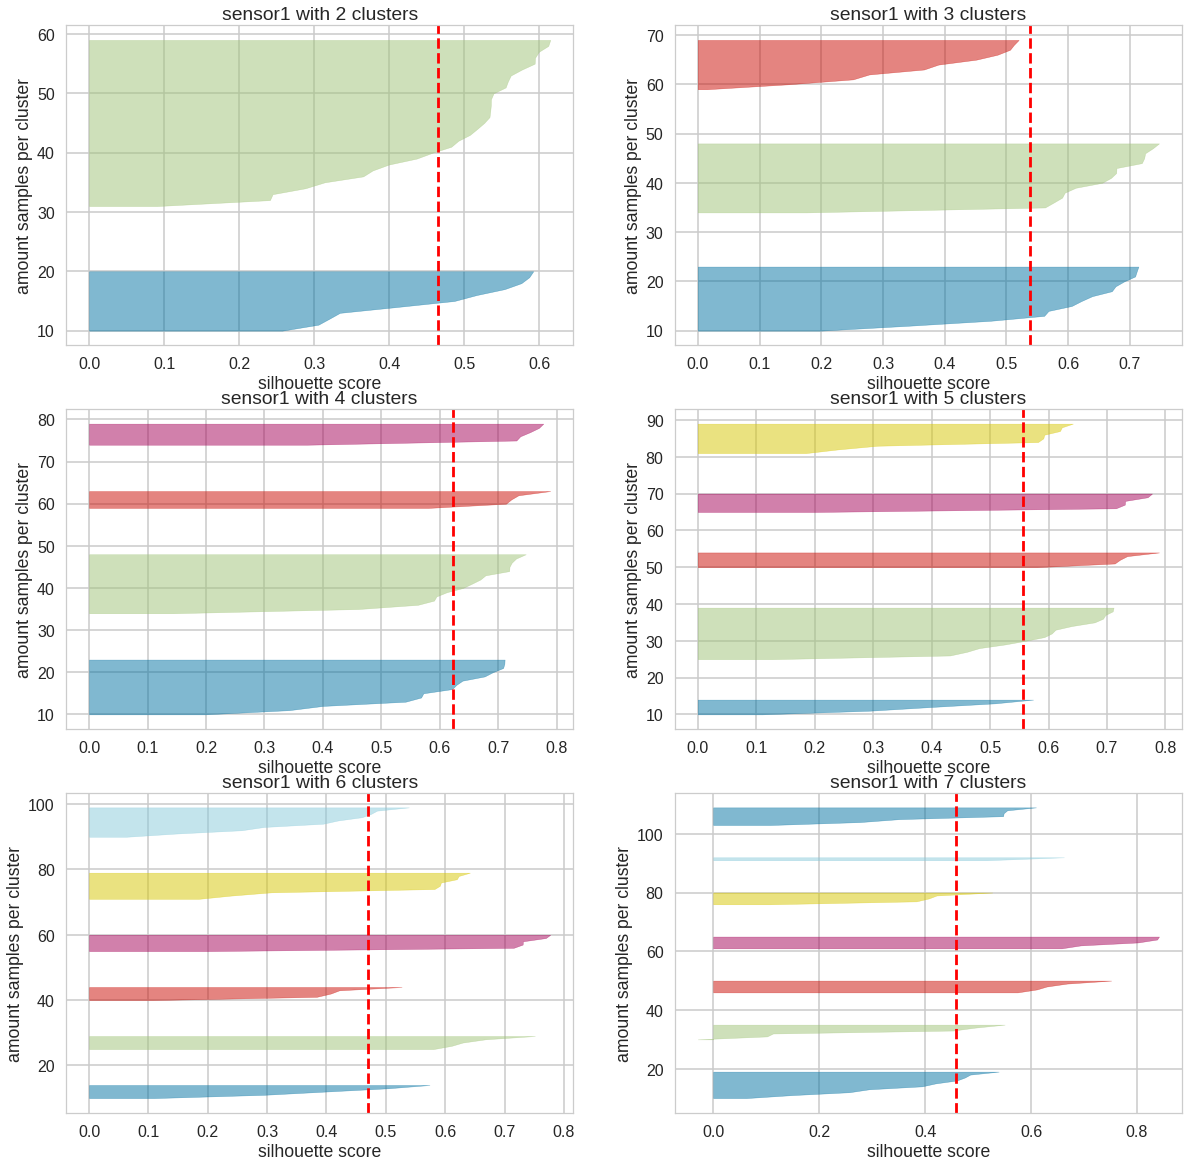

In [624]:
fig, ax = plt.subplots(3, 2, figsize = (20, 20))

pca_silhouette_scores = {}
pca_silhouette_scores['Ks'] = [2,3,4,5,6,7]
pca_silhouette_scores['sensor1'] = plotSilhoetteVisualizer(X = PCA_components['sensor1'].iloc[:,:2], 
                                                           Ks = pca_silhouette_scores['Ks'], 
                                                           ax = ax, 
                                                           sensorName = 'sensor1')

plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

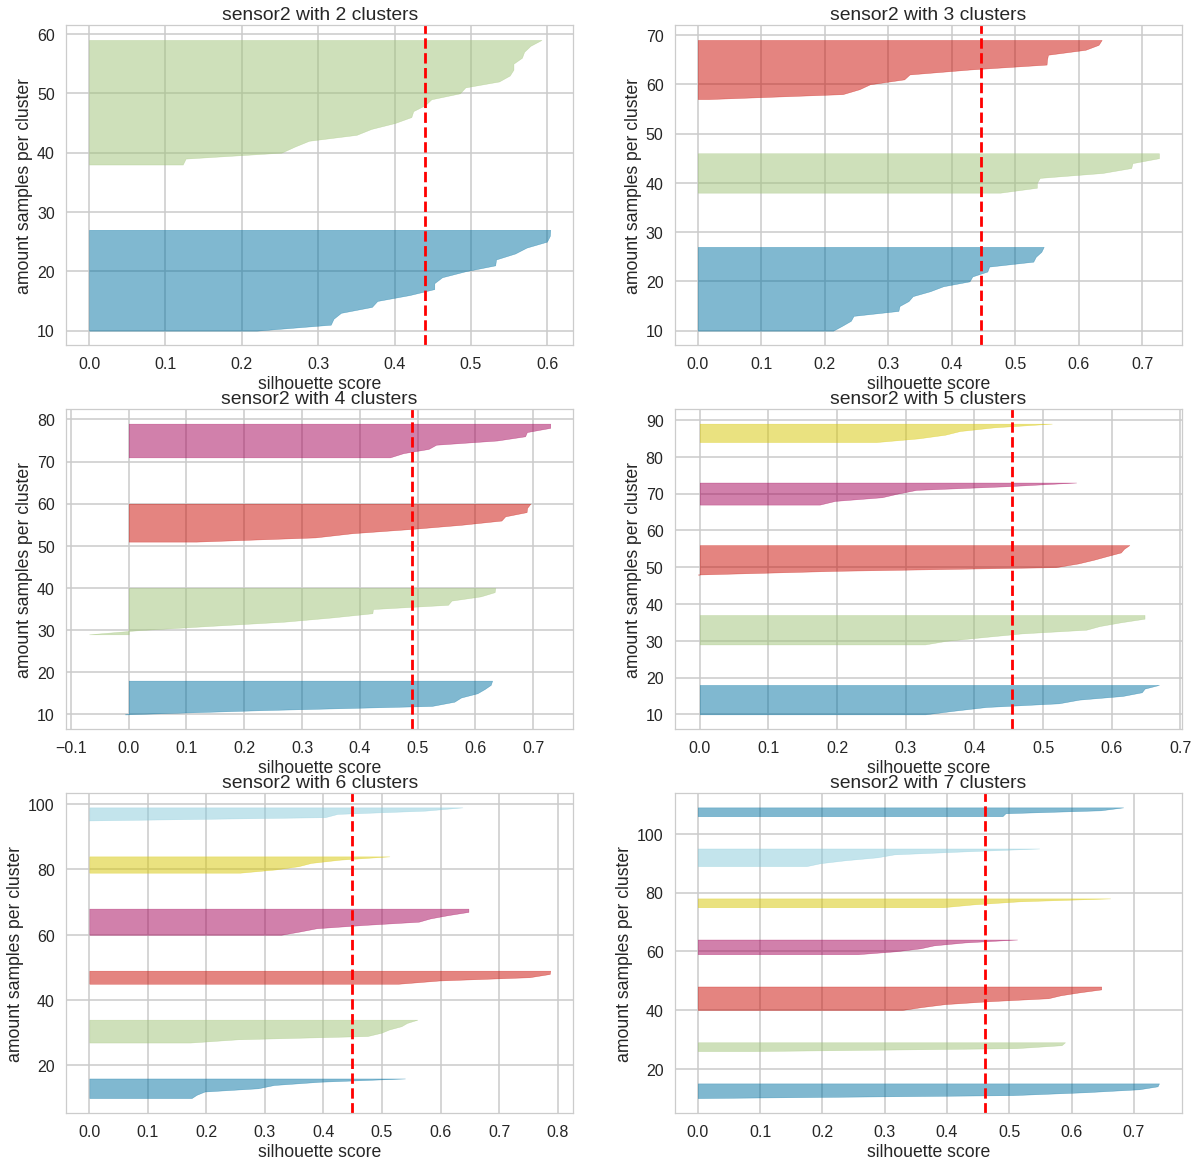

In [625]:
fig, ax = plt.subplots(3, 2, figsize = (20, 20))

pca_silhouette_scores['sensor2'] = plotSilhoetteVisualizer(X = PCA_components['sensor2'].iloc[:,:2], 
                                                           Ks = pca_silhouette_scores['Ks'], 
                                                           ax = ax, 
                                                           sensorName = 'sensor2')

plt.show()

In [626]:
best_K_sensor1 = getBestK(pca_silhouette_scores['sensor1'], pca_silhouette_scores['Ks'])
PCA_components['sensor1']['clusterPred'] = clusterPred(X = PCA_components['sensor1'].iloc[:, :2],
                                                       k = best_K_sensor1)

best_K_sensor2 = getBestK(pca_silhouette_scores['sensor2'], pca_silhouette_scores['Ks'])
PCA_components['sensor2']['clusterPred'] = clusterPred(X = PCA_components['sensor2'].iloc[:,:2],
                                                       k = best_K_sensor2)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


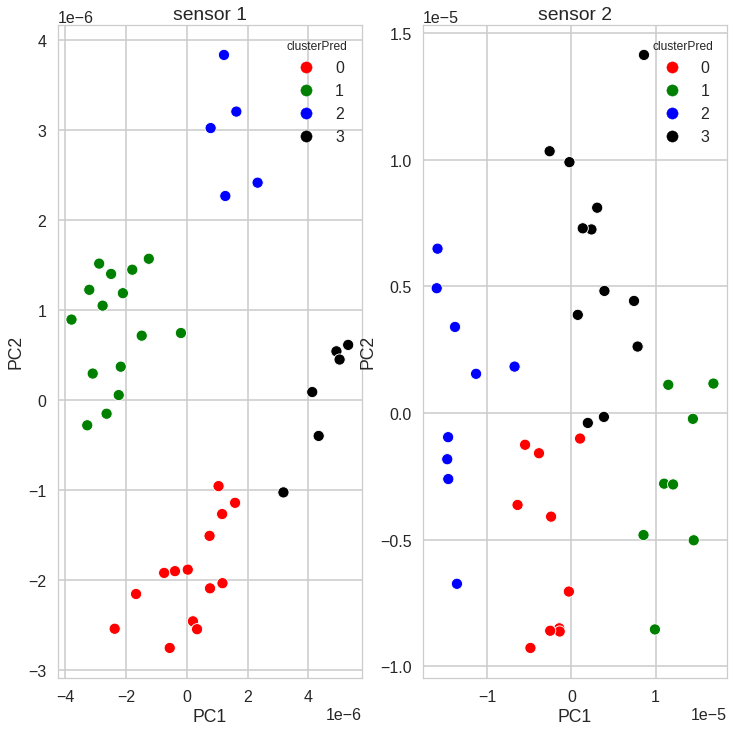

In [627]:
fig, ax = plt.subplots(1, 2, figsize = (12, 12))

plotPCA(df = PCA_components['sensor1'], 
        title = 'sensor 1', 
        ax = ax[0],
        target = 'clusterPred',
        palette = ['red', 'green', 'blue', 'black']
        )

plotPCA(df = PCA_components['sensor2'], 
        title = 'sensor 2', 
        ax = ax[1],
        target = 'clusterPred',
        palette = ['red', 'green', 'blue', 'black']
        )

plt.show()

## Fast Fourier Transform (FFT)

In [628]:
from scipy.fft import fft, fftfreq

def calculatingFFT(df, cols):
    new_df = pd.DataFrame(columns = cols)

    for i in range(len(df)):
        sample = df.iloc[i, :-4].values
        new_df.loc[i] = fft(sample)
        

    return new_df


fft_data = {}
fft_data['sensor1'] = calculatingFFT(raw_data['sensor1'], cols = raw_data['sensor1'].iloc[:,:-4].columns)
fft_data['sensor2'] = calculatingFFT(raw_data['sensor2'], cols = raw_data['sensor2'].iloc[:,:-4].columns)

fft_data['sensor1']['target'] = raw_data['sensor1']['target']
fft_data['sensor2']['target'] = raw_data['sensor2']['target']

/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


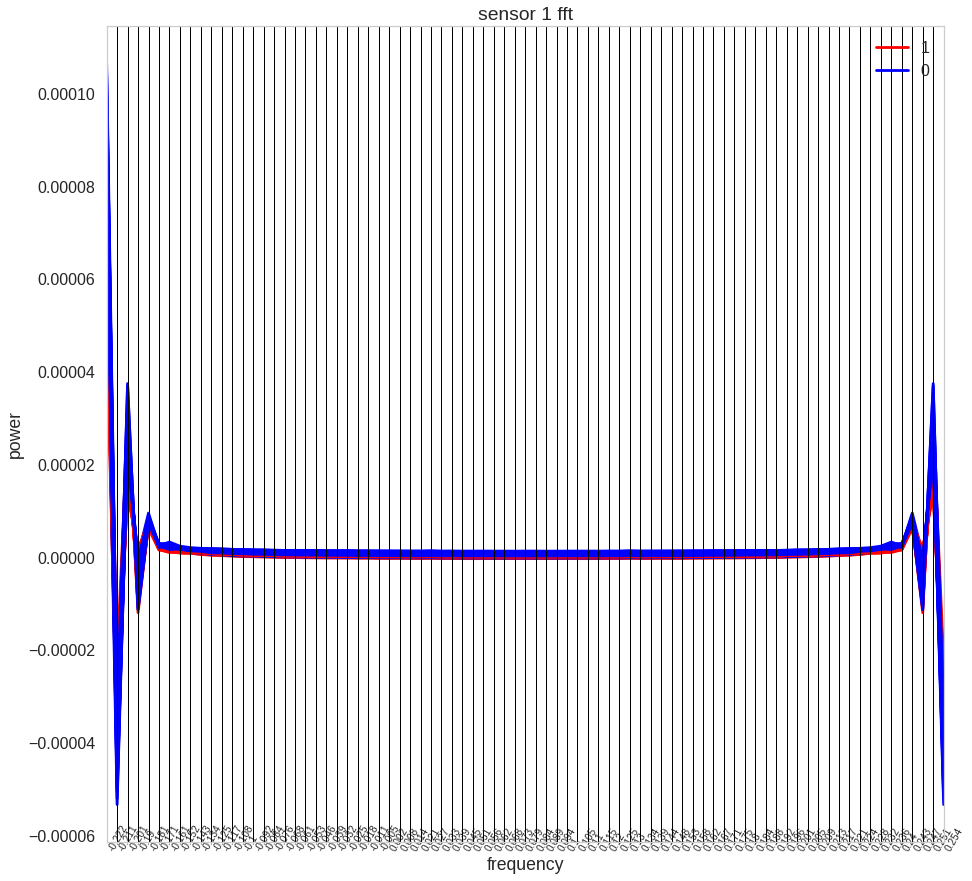

In [629]:
plotParallelCoordinates(df = fft_data['sensor1'],
                        title = 'sensor 1 fft',
                        xlabel = 'frequency',
                        ylabel = 'power',
                        target = 'target',
                        colors = ['red', 'blue'])

/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


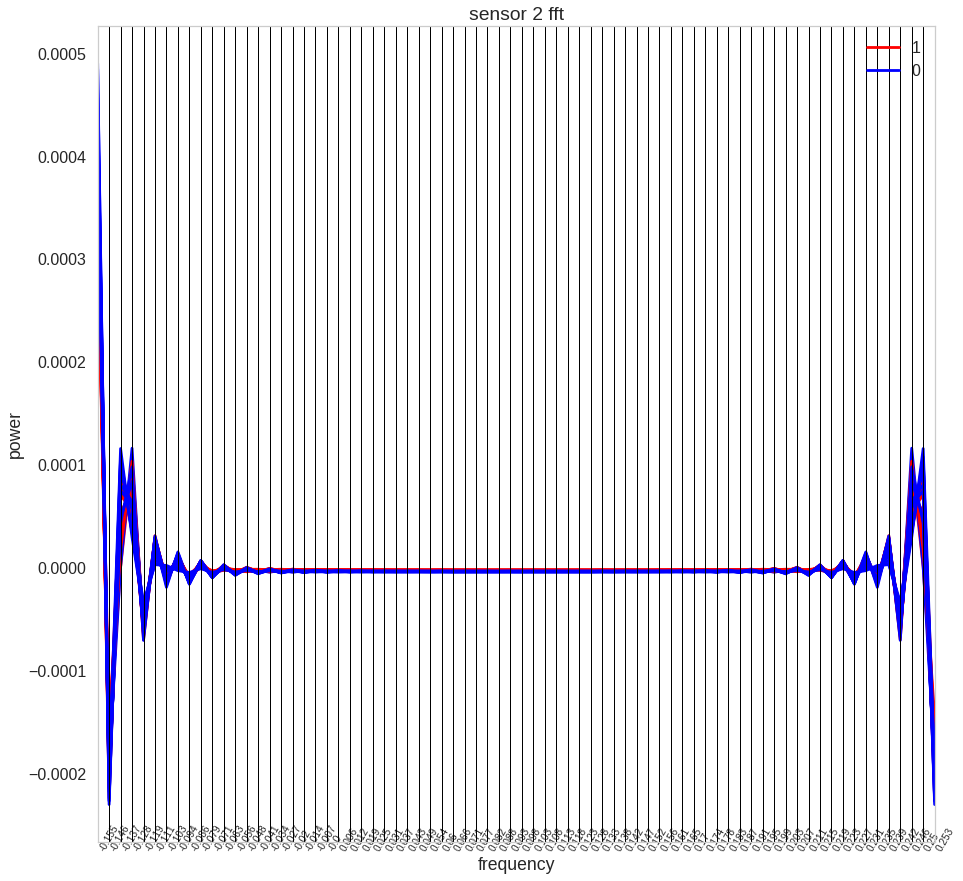

In [630]:
plotParallelCoordinates(df = fft_data['sensor2'],
                        title = 'sensor 2 fft',
                        xlabel = 'frequency',
                        ylabel = 'power',
                        target = 'target',
                        colors = ['red', 'blue'])